In [1]:
%run arm_forward_dynamics.ipynb

jit after {'jit': True, 'jit_options': {'flags': '-Ofast'}, 'compiler': 'shell'}
number of joints = 4
[115.143, 117.481, 3.3328, 177.52]
[115.143, 117.481, 3.3328, 177.52]
[3.31188, 3.45993, 2.63949, 60.0616]
[3.31188, 3.45993, 2.63949, 60.0616]
[1.91361, 1.33323, 0.992566, 3.16072, 0.0113272, -0.00275792, 0.00292854, -0.00220609]


In [2]:
# Define the necessary symbols
qref = cs.SX.sym('qref', ss.n_joints)  # Desired joint positions
Kp = cs.SX.sym('Kp', ss.n_joints)      # Proportional gain
Kd = cs.SX.sym('Kd', ss.n_joints)      # Derivative gain

err_dt = cs.SX.sym('err_dt')
# Error between reference and actual position
pd_err = qref - ss.q
prev_err = cs.SX.sym('prev_err', ss.n_joints)

derr_dt = (prev_err - pd_err)/err_dt


# Compute the PD control output
pd_controller = cs.diag(Kp)@pd_err + cs.diag(Kd)@derr_dt

u_pd = cs.Function('pid', [ss.q, ss.q_dot, qref, Kp, Kd, prev_err, err_dt], [pd_controller, pd_err])

u_pd.save('pid.casadi')

In [15]:
def experiment(qo = cs.vertcat(0.1,0.1,0.1,0.1), qref_ = np.array([0.1, 1.0, 0.5, 0.3])):
    import casadi as cs
    import numpy as np
    import matplotlib.pyplot as plt

    # Define the necessary symbols
    vo = cs.vertcat(0, 0, 0, 0)
    xo = cs.vertcat(qo, vo)
    nT = 300
    dt_ = 0.05
    Kp_ = cs.vertcat(20.0, 10.0, 10, 10.0)
    Kd_ = cs.vertcat(0.0, 0.0, 0.0, 0.0)

    # Initialize arrays for state and time
    X = np.zeros((nT+1, 8))  # Adjust size to include initial state
    T = np.zeros(nT+1)
    U = np.zeros((nT+1, 4))  # INPUT

    eerr_ = qref_ - np.array(cs.DM(qo)).reshape(4)

    # Include initial state
    X[0, :] = np.array(cs.DM(xo)).reshape(8)

    # Define the PD control function with integral term
    def u_pd(q, q_dot, qref_, Kp, Kd, eerr, dt):
        e = qref_ - q
        de = (e - eerr) / dt
        u = cs.diag(Kp) @ e + cs.diag(Kd) @ de
        u = cs.fmin(u, 1.0)  # Cap the input to a maximum value of 1
        u = cs.fmax(u, -1.0)  # Ensure the input is not less than -1
        return u, e

    # Simulation loop
    for i in range(1, nT+1):
        T[i] = i * dt_
        uuuu, eerr_ = u_pd(xo[:4], xo[4:], cs.DM(qref_), Kp_, Kd_, eerr_, dt_)
        U[i, :] = np.array(cs.DM(uuuu)).reshape(4)
        # Update state using your dynamics function F_next_arm
        xt_1 = cs.vertcat(xo[:4], xo[4:])
        fd_p = cs.vertcat(rigid_body_p_est, arm_Hyd__p_est, dt_, base_T0)
        xo = F_next_(xt_1, uuuu, fd_p)
        X[i, :] = np.array(cs.DM(xo)).reshape(8)

    # Define colors
    colors = ['r', 'g', 'b', 'c']

    # Plot displacement history
    plt.figure(figsize=(10, 6))
    for i in range(4):
        plt.plot(T, X[:, i], label=f'q{i+1}', color=colors[i])
        plt.axhline(y=qref_[i], color=colors[i], linestyle='--', label=f'q{i+1} ref')

    # Add labels and title
    plt.xlabel('Time, secs')
    plt.ylabel('Position (rad)')
    plt.title('Displacement history of the system')
    plt.legend()
    plt.show()

    # Plot velocity history
    plt.figure(figsize=(10, 6))
    for i in range(4):
        plt.plot(T, X[:, i+4], label=f'qdot{i+1}', color=colors[i])

    # Add labels and title
    plt.xlabel('Time, secs')
    plt.ylabel('Velocity (rad/s)')
    plt.title('Velocity history of the system')
    plt.legend()
    plt.show()

    # Plot control input history
    plt.figure(figsize=(10, 6))
    for i in range(4):
        plt.plot(T, U[:, i], label=f'u{i+1}', color=colors[i])

    # Add labels and title
    plt.xlabel('Time, secs')
    plt.ylabel('Control Input (Nm)')
    plt.title('Control Input history of the system')
    plt.legend()
    plt.show()


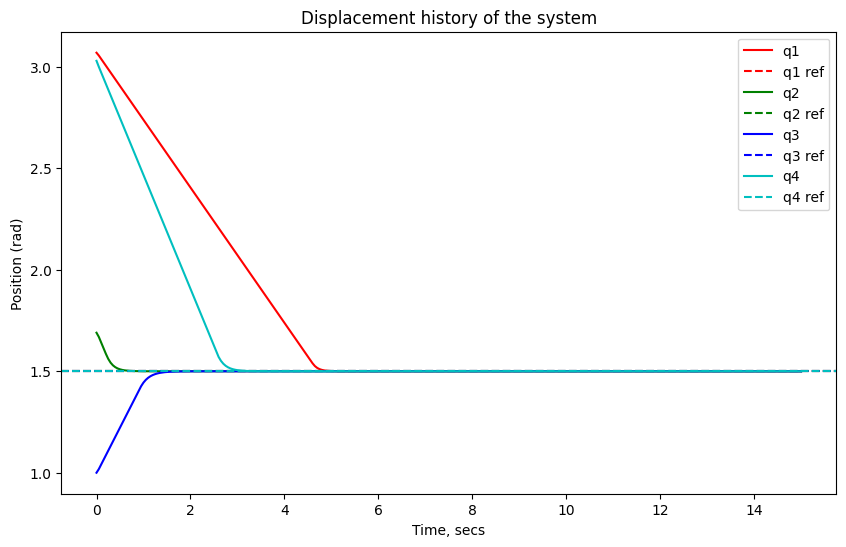

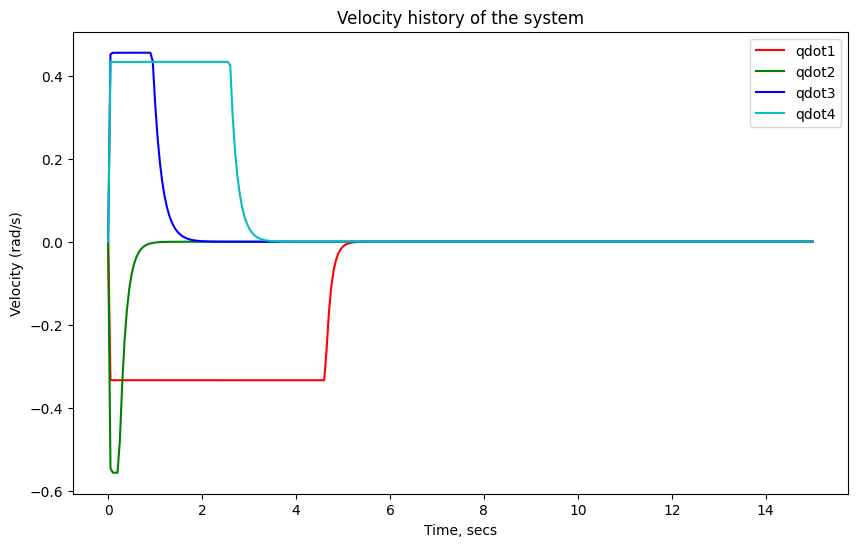

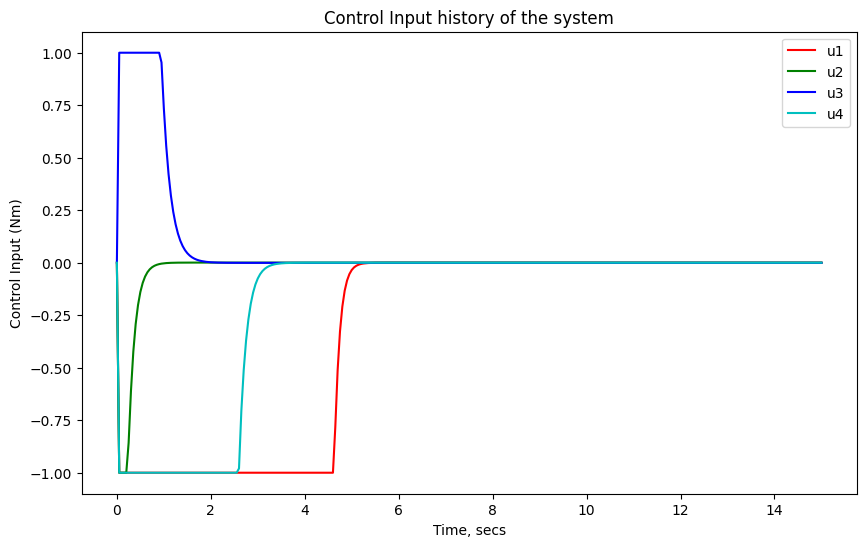

In [16]:
experiment(qo = cs.vertcat(3.07, 1.69, 1.00, 3.03), qref_ = np.array([1.5, 1.5, 1.5, 1.5]))